Demo for Chapter 2 of the course *Low rank models*, Geneva, Spring 2020.

Bart Vandereycken, last update on 20 March 2020.

# POD for ODEs: the cookie problem

This example implements POD for the cookie problem, as explained in Lecture 2.

**File needed in same directory as this notebook**: parametric_cookie_2x2_1580.mat

In [34]:
import numpy as np
import scipy.linalg as la
import scipy.io as sio

import matplotlib as mpl
from matplotlib import pyplot as plt

## 1. Load the problem

Load the matrices and the mesh. They come from MATLAB, hence the akward syntax. No need to understand all of this in detail. More explanation also follows below.

In [35]:
problem_cookie = sio.loadmat('parametric_cookie_2x2_1580.mat') 
A_all = problem_cookie['A'][0] # all the A
b = problem_cookie['b'].reshape(-1) # we need a 1D vector, not a Nx1 matrix
FreeDofs = problem_cookie['FreeDofs'][0]
U_bd = problem_cookie['U_bd'].astype(np.float64).reshape(-1) # we need floating points, not integers
mesh_elements = problem_cookie['Mesh']['Elements'][0][0]
mesh_coordinates = problem_cookie['Mesh']['Coordinates'][0][0]

# Construct a triangulation. The triangles are indexed by 1,2, ... in MATLAB hence -1
tri = mpl.tri.Triangulation(x=mesh_coordinates[:,0], y=mesh_coordinates[:,1], triangles=mesh_elements-1)

Let us plot the mesh itself. More info: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.triplot.html

Text(0.5, 1.0, 'Triangulation')

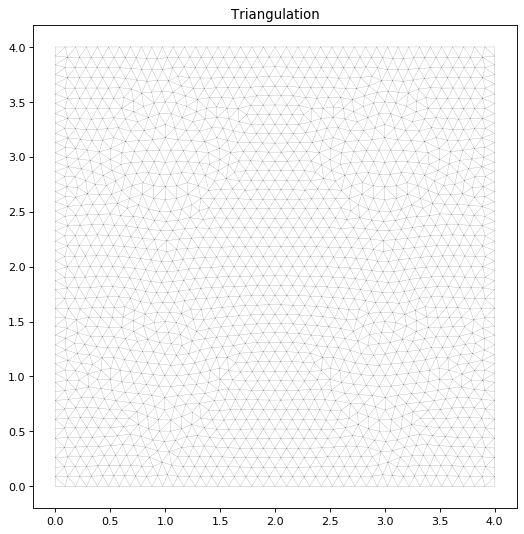

In [36]:
# Plot only the triangles
fig,ax=plt.subplots(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k') # to have bigger plots
ax.set_aspect('equal')
ax.triplot(tri, lw=0.2, color = 'grey')
ax.set_title('Triangulation')

The FEM matrices representing $A$ are stored in `A_all`. They are constructed so that we can change the conductivity coefficient $\alpha_i$ for each cookie $i$:
$$
 A = -A_0 - \sum_{i=1}^4 \alpha_i \cdot A_i 
$$
where $A_i$ is stored as `A_all[i]`. Notice the minus signs. Here $A_0$ is the FEM matrix of the whole square with conductivity $1$. So $\alpha_i=100$ gives a conductivity of $101$ for cookie $i$.

## 2. Define the ODE and solve it

We take three cookies with conductivity coefficient $101$ and one with $1$. That means that the FEM matrix satisfies
$$
 A = -A_0 - 100 \cdot (A_1 + A_2 + A_3) .
$$ 
Let us define the ODE and solve it with the standard ODE solver in Python. It is good to check that the integration method says it succeeded. More info: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [37]:
from scipy.integrate import solve_ivp

A = A_all[0] + 100*(A_all[1] + A_all[2] + A_all[3]) # 3 cookies
def fun_ode(t,y):  # the function defining the ODE
    dy = -A.dot(y) + b  # y' = f(t,y) = A*y+b
    return dy

y0 = np.zeros(b.shape)  # initial condition
t_span = [0, 500]       # time interval for integration

# Since this is a stiff ODE, one should use an implicit method like Radau.
# The standard choice of RK45, which is an explicit method, is much slower.
# On my laptop: 11 vs 36 secs. But this difference will increase for larger problems.
ode_method = 'Radau'
#ode_method = 'RK45' 

sol_ode = solve_ivp(fun_ode, t_span, y0, method=ode_method, dense_output=True, atol=1e-10, rtol=1e-10)
sol_ode.message

'The solver successfully reached the end of the integration interval.'

We do not get the solution $y(t)$ as an explicit function but we can evaluate it as `sol_ode.sol(t)`. That is good enough numerically.

In [10]:
yt = sol_ode.sol(500)  # time 500      
print(yt.shape)
yt[4:10]

(1580,)


array([0.55925188, 0.55909039, 0.5586806 , 0.55803578, 0.55720954,
       0.55619414])

Now, we plot this solution $y(t)$ on the mesh. More info (see demos): https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tricontourf.html

**Remark**: The solution `yt` from above needs to be combined with the boundary before we can plot it on the mesh.

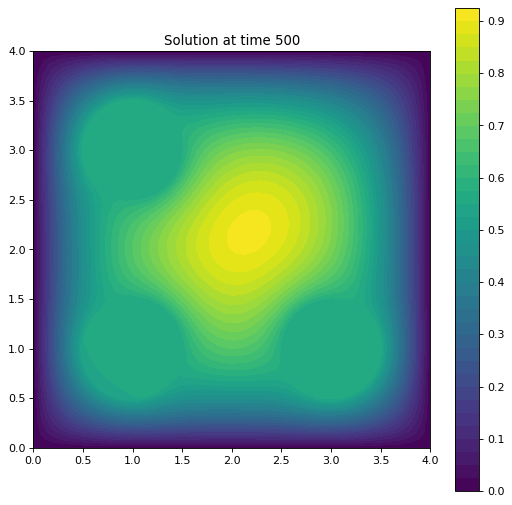

In [16]:
# Combine solution with boundary solution.
def add_boundary(y):
    u = U_bd.copy() # just to be sure, copy
    u[FreeDofs-1] = y  # MATLAB indices start with 1
    return u

def plot_solution(y, title=None):
    u = add_boundary(y)
    
    # Now plot. Countourf seems to be the standard choice.
    fig,ax=plt.subplots(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax.set_aspect('equal')
    #ax.triplot(tri, lw=0.1, color = 'white')  # wireframe of mesh
    tcf = ax.tricontourf(tri, u, 40)  # automatic N levels
    #tcf = ax.tricontourf(tri, u, levels=np.linspace(0,1.18,100))  # hardcoded after finding that max is 1.1779
    fig.colorbar(tcf)
    if title is not None:
        ax.set_title(title)
           
plot_solution(yt, title='Solution at time 500')

We can also plot all solutions $y_k(t_1), y_k(t_2), \ldots, y_k(t_n)$ at a particular mesh point. With some guessing, we determine that index $k=1000$ is close to the middle of the mesh.

(1580, 100)


array([2.16255294, 2.18085897])

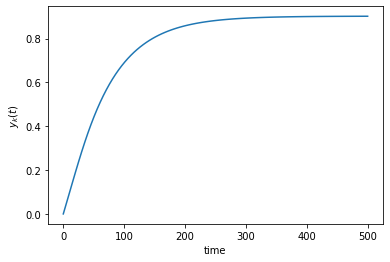

In [17]:
ts = np.linspace(t_span[0], t_span[1], 100) # 100 time points
Y = sol_ode.sol(ts)  # We can evaluate for all times in ts. 
                     # Column Y[:,i] is for time ts[i]
print(Y.shape)
plt.plot(ts, Y[1000,:])
plt.xlabel('time')
plt.ylabel('$y_k(t)$')
mesh_coordinates[1000,:]

Observe that the value $y_k(t)$ has more or less reached it limit. Hence, we have integrated long enough.

# 3. Model reduction by POD

Perform POD to reduce the ODE as explained in the lecture notes. For simplicity -- or more honestly, laziness! -- we take the sample points equidistant in the integration interval. 

*The equidistant points are actually not too wrong. But the correct computation with a Gauss quadrature formula is an exercise for you!*

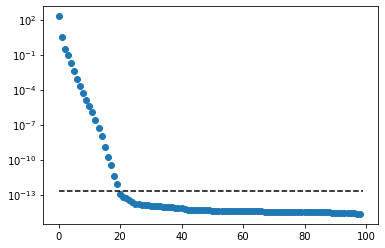

In [20]:
N_pod = 100
Y_pod = sol_ode.sol(np.linspace(t_span[0], t_span[1], N_pod))
s = la.svdvals(Y_pod)
plt.semilogy(s, 'o')
plt.semilogy(np.repeat(1e-15*s[0], len(s)), 'k--') # the numerical error is eps_mach * |A|_2
plt.savefig('cookie_svals.pdf')

The singular values decay quickly up to the machine accuracy (indicated by the black dashed line). Let us try a subspace of dimension 10.

In [23]:
U,s,Vt = la.svd(Y_pod)
k = 10
UU = U[:,:k]
la.norm(s[k:]) # expected relative error (in Frobenius norm)

4.05307118752201e-06

Compute the reduced matrix and define the corresponding reduced ODE.

In [24]:
A_reduced = UU.T.dot( A.dot(UU) )
b_reduced = UU.T.dot(b)

def fun_ode_reduced(t,alpha):
    dalpha = -A_reduced.dot(alpha) + b_reduced
    return dalpha

Solve the reduced ODE and compare its solution to the exact one.

The solver successfully reached the end of the integration interval.


/Users/benjamincarrel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Text(0, 0.5, 'error at time t')

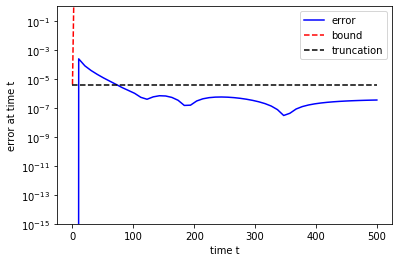

In [25]:
alpha0 = np.zeros(b_reduced.shape)
sol_ode_reduced = solve_ivp(fun_ode_reduced, t_span, alpha0, method=ode_method, dense_output=True, atol=1e-10, rtol=1e-10) 
print(sol_ode_reduced.message)

# compute error on ts
ts = np.linspace(t_span[0], t_span[1], 50)
Y_exact = sol_ode.sol(ts)
alpha_reduced = sol_ode_reduced.sol(ts)   
Y_reduced = UU.dot(alpha_reduced)  # \tilde y = U alpha

err = []
for i in range(len(ts)):
    err.append( la.norm(Y_reduced[:,i] - Y_exact[:,i]) )

# error bound as in lecture notes
CA = la.norm(A_all[0].todense(), 2)
T = t_span[1]

err_bound = np.sqrt(np.exp(2*CA*ts))*la.norm(s[k:]) # the exp will overflow due to large result; ignore!
trunc_err = np.repeat(la.norm(s[k:]), len(ts), )
plt.semilogy(ts, err, 'b-')
plt.semilogy(ts, err_bound, 'r--')
plt.semilogy(ts, trunc_err, 'k--')
plt.legend(['error', 'bound', 'truncation'])
plt.ylim([1e-15, 1])
plt.xlabel('time t')
plt.ylabel('error at time t')

We see that the reduced ODE is integrated fairly accurately, about on the level of the truncation error of 1e-5. Unfortuntately, our bound that we saw in the lecture is not very accurate -- in fact, it is completely useless! This is because the ODE has a large Lipschitz constant $C_A$. There exist better bounds for this kind of problem that explain more accurately the observed error, but that is more advanced and beyond the scope of the course. (They use one-sided Lipschitz constants.)

## 4. POD subspace dimension and error

Let us verify that the error decreases when we increase the POD subspace. First, we wrap the calculation from above in a function so we can easily change this dimension.

In [26]:
def compute_POD_solution(k, U, ts, Y_exact):  
    UU = U[:,:k]
    trunc_err = la.norm(s[k:]) 
    
    A_reduced = UU.T.dot( A.dot(UU) )
    b_reduced = UU.T.dot(b)

    def fun_ode_reduced(t,alpha):
        dalpha = -A_reduced.dot(alpha) + b_reduced
        return dalpha
    
    alpha0 = np.zeros(b_reduced.shape)
    sol_ode_reduced = solve_ivp(fun_ode_reduced, t_span, alpha0, method=ode_method, dense_output=True, atol=1e-10, rtol=1e-10) 
    print(sol_ode_reduced.message)
    
    alpha_reduced = sol_ode_reduced.sol(ts)   
    Y_reduced = UU.dot(alpha_reduced) 
    
    # trick to avoid the loop of above: compute norm along 0th axis (ie, each column)
    err = la.norm(Y_reduced - Y_exact, axis=0)
    return err, trunc_err    

Now compute for different dimensions of the subspace, and plot the errors.

In [28]:
U,s,Vt = la.svd(Y_pod)
ts = np.linspace(t_span[0], t_span[1], 50)
Y_exact = sol_ode.sol(ts)

err_5, trunc_err_5   = compute_POD_solution(5, U, ts, Y_exact)
err_10, trunc_err_10 = compute_POD_solution(10, U, ts, Y_exact)
err_20, trunc_err_20 = compute_POD_solution(20, U, ts, Y_exact)
err_30, trunc_err_30 = compute_POD_solution(30, U, ts, Y_exact)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


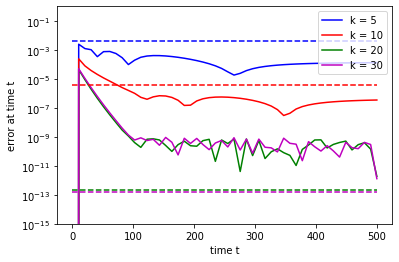

In [29]:
plt.semilogy(ts, err_5, 'b-')
plt.semilogy(ts, err_10, 'r-')
plt.semilogy(ts, err_20, 'g-')
plt.semilogy(ts, err_30, 'm-')
plt.semilogy(ts, np.repeat(trunc_err_5, len(ts)), 'b--')
plt.semilogy(ts, np.repeat(trunc_err_10, len(ts)), 'r--')
plt.semilogy(ts, np.repeat(trunc_err_20, len(ts)), 'g--')
plt.semilogy(ts, np.repeat(trunc_err_30, len(ts)), 'm--')

plt.legend(['k = 5', 'k = 10', 'k = 20', 'k = 30'])
plt.ylim([1e-15, 1])
plt.xlabel('time t')
plt.ylabel('error at time t')
plt.savefig('POD_error.pdf')

The error seems to decay nicely for increasing $k=5, 10, 20$. However, compared to the truncation error, it is not so good and the error seems to be quite large for small $t$. For $k=30$, we see no more improvement. This is likely due to numerical error in the integration of the ODEs.

*When using Gauss quadrature, the error behavior for small $t$ will improve a lot.*

## 5. Timing

The POD reduced model is constructed to be faster in computation. Let us verify this here for the original model compared to the POD with $k=20$.

Timing code can be done easily in Python with the magic command `%timeit` (notice the %).

In [30]:
# timeit normally, but takes too long here?
U,s,Vt = la.svd(Y_pod)
ts = np.linspace(t_span[0], t_span[1], 50)
Y_exact = sol_ode.sol(ts)

def compute_only_POD(k):
    UU = U[:,:k]
    
    A_reduced = UU.T.dot( A.dot(UU) )
    b_reduced = UU.T.dot(b)

    def fun_ode_reduced(t,alpha):
        dalpha = -A_reduced.dot(alpha) + b_reduced
        return dalpha
    
    alpha0 = np.zeros(b_reduced.shape)
    sol_ode_reduced = solve_ivp(fun_ode_reduced, t_span, alpha0, method=ode_method, dense_output=True, atol=1e-10, rtol=1e-10) 
    return sol_ode_reduced

# original ODE:
%timeit solve_ivp(fun_ode, t_span, y0, method=ode_method, dense_output=True, atol=1e-10, rtol=1e-10) #, args=(f, k, Du, Dv, dx)
# reduced ODE:
%timeit compute_only_POD(20)

22.5 s ± 5.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
286 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my laptop, the reduced ODE takes on average 243 *microseconds*, whereas the original ODE takes 10.2 *seconds*. That is about 10.2 / 0.243 = 42 times faster! Observe that the size of the original matrix is 1580 by 1580, which is not even that large. For larger problems, this speedup will be greater.